# Real vs Fake Job Classification NLP Pipeline ML and Deep Learning
By : Kene Eyisi

In [347]:
#Importing dependencies
!pip install missingno
!pip install wordcloud
!pip install spacy
!pip install matplotlib
!pip install xgboost

import re
import string
import numpy as np
import pandas as pd
import random
import missingno
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.gridspec import GridSpec
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix

from wordcloud import WordCloud

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


In [348]:
#Importing file from directory
job_postings = pd.read_csv('/fake_job_postings.csv')


In [356]:
# Viewing first 5 rows of the data.
# Useful for getting a general understanding of the data and the structure of the dataframe. 
# Also used to quickly check if the dataframe has been loaded correctly and if the first few rows match the expected data
job_postings.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [350]:
# Get summary info of dataset
job_postings.info()
job_postings.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

****From describing our data above we get to know that their are 4 columns named as job_id, telecommuting, has_company_logo and has_questions features which have numerical data. 
It also shows the numerical feature 'fraudulent' which is the column on which our model will be trained and predicted****

/Users/keen/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,fraudulent,title
0,0,17014
1,1,17014


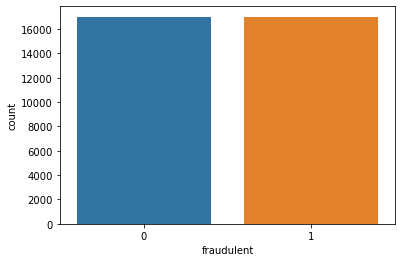

In [477]:
# Visualising distribution of the target variabe 'fraudulent'
sns.countplot(job_postings.fraudulent)
job_postings.groupby('fraudulent').count()['title'].reset_index().sort_values(by='title',ascending=False)

***The histogram above shows a high imbalance between real vs fake job posting, hence extra processing is required for an adequate test for the model****

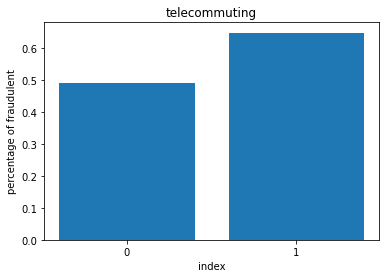

The percentage of fraudulent for index 0 is 49.1%
The percentage of fraudulent for index 1 is 64.8%


In [485]:
# Visualising what proportion of the fake jobs are identified within a categorical variable such as telecommuting
# 0 represents no telecommuting option, while 1 represents availability of telecommuting in the job
telecommuting=job_postings.groupby('telecommuting').mean()['fraudulent']
plt.title('telecommuting')
plt.xlabel('index')
plt.ylabel('percentage of fraudulent')
plt.bar(np.array(seri.index,dtype='str'),telecommuting)
plt.show()
for index in telecommuting.index:
    percentage = telecommuting.at[index]
    print("The percentage of fraudulent for index {} is {:.1f}%".format(index, percentage*100))


***The histogram above shows that job postings that allow telecommunting are more likely to be classified as fake***

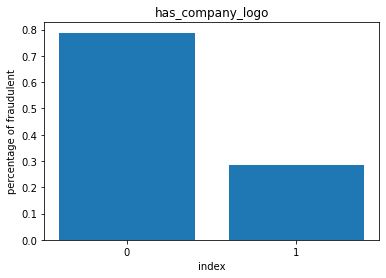

The percentage of fraudulent for index 0 is 78.8%
The percentage of fraudulent for index 1 is 28.5%


In [484]:
# Visualising what proportion of the fake jobs are identified within a categorical variable such as company logo
# 0 represents false for has_company_logo, while 1 represents true for has_company_logo
comp_logo=job_postings.groupby('has_company_logo').mean()['fraudulent']
plt.title('has_company_logo')
plt.xlabel('index')
plt.ylabel('percentage of fraudulent')
plt.bar(np.array(seri.index,dtype='str'),comp_logo)
plt.show()
for index in comp_logo.index:
    percentage = comp_logo.at[index]
    print("The percentage of fraudulent for index {} is {:.1f}%".format(index, percentage*100))

***The histogram above shows that job postings that do not have company logo are more likely to be classified as fake***

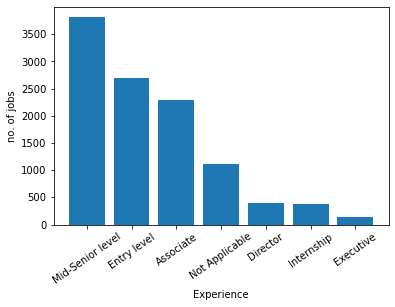

In [357]:
# Visualising the experience level which is most required by jobs
experience = dict(job_postings.required_experience.value_counts())
if ' ' in experience:
    del experience[' ']
plt.bar(experience.keys(), experience.values())
plt.xlabel('Experience', size=10)
plt.ylabel('no. of jobs', size=10)
plt.xticks(rotation=35)
plt.show()

***The histogram above shows that Mid-senior level is the most common job level in the postings***

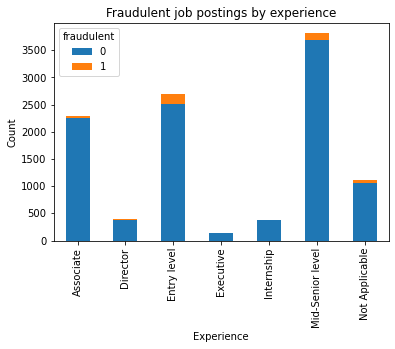

In [358]:
# Visualising the job required experience and their distribution between fake and real 
#group the data by the "experience" and "fraudulent" variables
data_grouped = job_postings.groupby(['required_experience', 'fraudulent']).size()

# plot the histogram
data_grouped.unstack().plot(kind='bar', stacked=True)
plt.title('Fraudulent job postings by experience')
plt.xlabel('Experience')
plt.ylabel('Count')
plt.show()

In [359]:
#find the "required experience" with the highest number of fraudulent job postings
#number of fraudulent job postings
fraud_count = job_postings[job_postings["fraudulent"] == 1].shape[0]

#get the required experience with the highest number of fraudulent job postings
max_experience = job_postings[job_postings["fraudulent"] == 1].groupby("required_experience").size().idxmax()

#number of fraudulent job postings for that experience
max_count = job_postings[(job_postings["required_experience"] == max_experience) & (job_postings["fraudulent"] == 1)].shape[0]

# calculate the percentage
percentage = (max_count/fraud_count) * 100

#print the result
print('The required experience with the highest number of fraudulent job postings is {} with {} job postings, which represents {:.2f}% of the total number of fraudulent job postings.'.format(max_experience, max_count, percentage))

The required experience with the highest number of fraudulent job postings is Entry level with 179 job postings, which represents 20.67% of the total number of fraudulent job postings.


In [360]:
# Checking the number of unique industries
num_unique_industries = len(job_postings["industry"].unique())
print("The number of unique industries is:", num_unique_industries)

The number of unique industries is: 132


***The outcome shows the industry with the highest number of fake job posting is "Oil & Energy"***

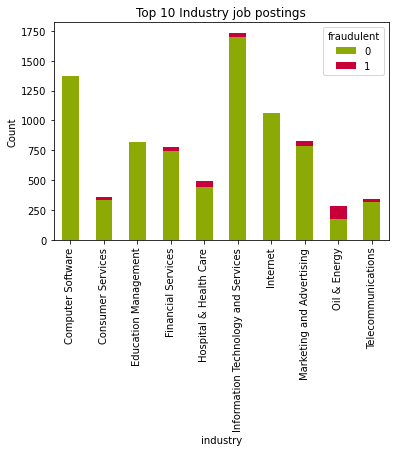

In [361]:
# Select top n industries
n = 10
top_industries = job_postings['industry'].value_counts().nlargest(n).index

# Filter the dataframe to include only the top n industries
job_postings_top_industries = job_postings[job_postings['industry'].isin(top_industries)]

#group the data by the "industry" and "fraudulent" variables
data_grouped_top_industries = job_postings_top_industries.groupby(['industry', 'fraudulent']).size()

# plot the histogram
data_grouped_top_industries.unstack().plot(kind='bar', stacked=True, color=['#8DA905','#C70039'])
plt.title('Top {} Industry job postings'.format(n))
plt.xlabel('industry')
plt.ylabel('Count')
plt.show()

In [362]:
#find the Industry with the highest number of fraudulent job postings
#number of fraudulent job postings
fraud_count = job_postings[job_postings["fraudulent"] == 1].shape[0]

#get the required experience with the highest number of fraudulent job postings
max_experience = job_postings[job_postings["fraudulent"] == 1].groupby("industry").size().idxmax()

#number of fraudulent job postings for that experience
max_count = job_postings[(job_postings["industry"] == max_experience) & (job_postings["fraudulent"] == 1)].shape[0]

# calculate the percentage
percentage = (max_count/fraud_count) * 100

#print the result
print('The Industry with the highest number of fraudulent job postings is {} with {} job postings, which represents {:.2f}% of the total number of fraudulent job postings.'.format(max_experience, max_count, percentage))

The Industry with the highest number of fraudulent job postings is Oil & Energy with 109 job postings, which represents 12.59% of the total number of fraudulent job postings.


In [363]:
# Visualising the industry that has the most fake job postings
job_postings_industry = job_postings[job_postings['fraudulent']== 1]
job_postings_industry.shape

(866, 18)

In [364]:
# Checking the most frequent job title in the dataset
print(job_postings.title.value_counts()[:10])


English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        75
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


***The outcome shows English Teacher abroad as the most occuring job title***

In [365]:
# Combining text into a single column to start cleaning the data
# Creating a new dataframe to handle the combined data
new_job_posting = job_postings.copy()

In [366]:
# Combining text into a single column to visualise with wordcloud
new_job_posting['text']=new_job_posting['title']+' '+new_job_posting['location']+' '+new_job_posting['company_profile']+' '+new_job_posting['description']+' '+new_job_posting['requirements']+' '+new_job_posting['benefits']
del new_job_posting['title']
del new_job_posting['location']
del new_job_posting['department']
del new_job_posting['company_profile']
del new_job_posting['description']
del new_job_posting['requirements']
del new_job_posting['benefits']
del new_job_posting['required_experience']
del new_job_posting['required_education']
del new_job_posting['industry']
del new_job_posting['function']
del new_job_posting['salary_range']
del new_job_posting['telecommuting']
del new_job_posting['has_company_logo']
del new_job_posting['has_questions']
del new_job_posting['employment_type']

In [486]:
# Dropping Nan Values
new_job_posting = new_job_posting.dropna()
new_job_posting.head()

,job_id,fraudulent,text
1,2,0,"Customer Service - Cloud Video Production NZ, ..."
3,4,0,"Account Executive - Washington DC US, DC, Wash..."
4,5,0,"Bill Review Manager US, FL, Fort Worth SpotSou..."
6,7,0,"Head of Content (m/f) DE, BE, Berlin Founded i..."
7,8,0,"Lead Guest Service Specialist US, CA, San F..."


In [368]:
# Determining the most frequent words that occur in fraud and actual jobs using wordcloud
fakejobs_text = new_job_posting[new_job_posting.fraudulent==1].text
realjobs_text = new_job_posting[new_job_posting.fraudulent==0].text

In [487]:
# Mapping texts to lists
fakejobs_text = list(map(str,fakejobs_text))
realjobs_text = list(map(str,realjobs_text))

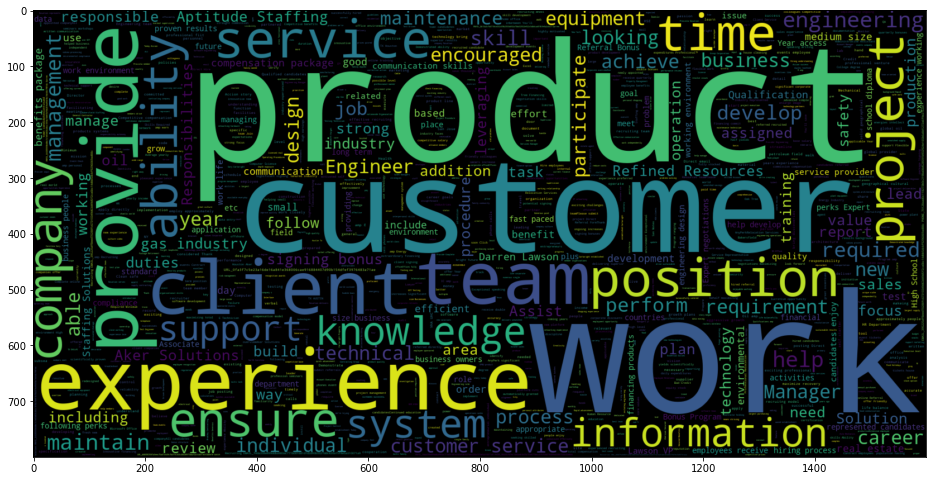

In [370]:
# Word cloud showing most ocurring words in fake job postings
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(fakejobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

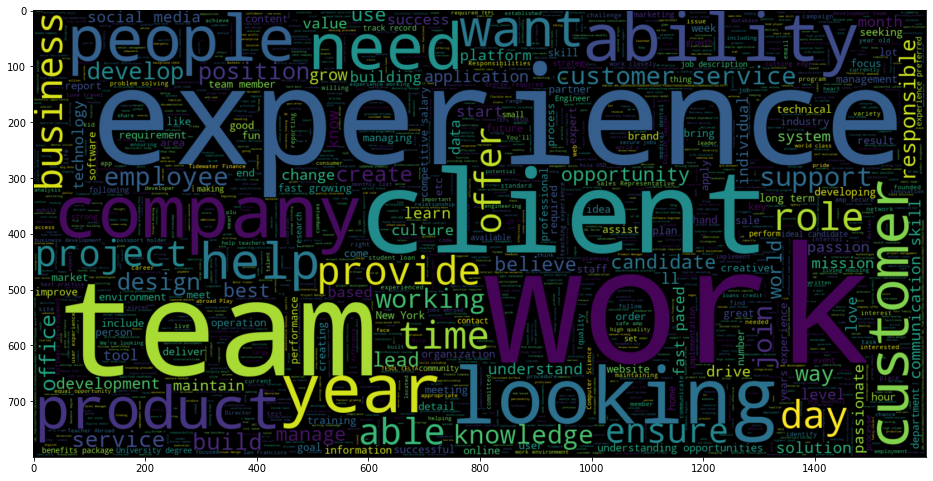

In [371]:
# Word cloud showing most ocurring words in Real job postings
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(realjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

# Text cleaning and normalization
***The first re.sub() line removes all punctuation and special characters from the text by replacing them with a single space, using the regular expression [^a-zA-Z0-9].
The next line converts all the characters to lowercase using the .lower() method.
The next line removes all numbers from the text by replacing them with a single space, using the regular expression \b\d+\b.
The last line removes any extra whitespace within the text by replacing multiple spaces with a single space, using the regular expression ' +'.***

In [372]:
import re

def text_cleaning(text):
    # Check if the input is a string
    if not isinstance(text, str):
        return text
    # Remove punctuation and special characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # Convert to lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"\b\d+\b", " ", text)
    # Remove extra whitespace
    text = re.sub(' +', ' ', text)
    return text

# Apply the text cleaning function to all the text columns
for column in text_columns:
    job_postings[column] = job_postings[column].apply(text_cleaning)


# Removing stop words
***imports the stopwords corpus from the nltk library, which contains a list of commonly used stop words in the English language.
Then defines a function remove_stopwords() that takes in a string as input, checks if it's a string, and removes all the stopwords from it. Inside the function, it creates a list of words from the input text using the .split() method which splits the text into words. Then it uses a list comprehension to filter out the words that are in the stop_words list. The filtered words are then joined back into a single string using the join() method.
The for loop applies this function to all the columns in the text_columns list, using the apply() function and lambda function. This function applies the remove_stopwords() function to each element in the column, which results in all the text columns have stop words removed.***

In [373]:
from nltk.corpus import stopwords

# Creating a list of stopwords in English
stop_words = set(stopwords.words("english"))

# Defining a function to remove stopwords from the text
def remove_stopwords(text):
    # Check if the input is a string
    if not isinstance(text, str):
        return text
    filtered_sentence = [w for w in text.split() if w not in stop_words]
    return " ".join(filtered_sentence)

# Applying the function to the 'text' column of the new_job_posting dataframe
for column in text_columns:
 job_postings[column] = job_postings[column].apply(lambda x: remove_stopwords(x))


# Balancing The Dataset
***After performing EDA, we saw earlier from the histogram that the data is imbalanced. 
The next step is to fix the imbalance by oversampling the minority class.
This is to ensure that we avoid bias in the model outputs
Random sampling oversampling is applied to balance the data***

In [374]:
# Count the number of fraudulent variables
job_postings['fraudulent'].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

In [375]:
# Separate the fraudulent and non fraudulent dataframes
job_postings['fraudulent'].values

array([0, 0, 0, ..., 0, 0, 0])

In [376]:
# Visualising the count distribution of fake posts 
fake = job_postings[job_postings['fraudulent']== 1]
fake.shape

(866, 18)

In [377]:
# Visualising the count distribution of real posts 
not_fake = job_postings[job_postings['fraudulent']== 0]
not_fake.shape

(17014, 18)

In [378]:
# Performing oversampling to get a balanced dataset
fake = fake.sample(17014, replace=True)

In [488]:
# Visualising the count of the balanced dataset 
fake.shape, not_fake.shape

((17014, 18), (17014, 18))

In [380]:
# The fake and not_fake dataframes are concatenated to create a new dataframe job_postings containing all the rows from both dataframes.
# The reset_index() function resets the index of the dataframe, so that the index starts from 0 and is incremented by 1 for each row. If the dataframe has a multi-level index, it removes one or more levels. This is useful for ensuring that the index is consistent and easy to work with.
job_postings = fake.append(not_fake)
job_postings.reset_index()

/var/folders/3n/c7x7slqd16z7xbdfmsycfvfm0000gn/T/ipykernel_70721/583256487.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  job_postings = fake.append(not_fake)


,index,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,17688,17689,user experience designer mobile,ap hyderabad,user experience design,1234-12345,NaN,looking ux designer help us continuously innov...,adept experienced various user research usabil...,kill set technology skills proficient interact...,0,0,0,full time,mid senior level,master degree,design,art creative,1
1,8702,8703,data processing agent,us ny new york,NaN,NaN,NaN,seeking individuals connected companies hiring...,home office suppliescomputer internet accessqu...,NaN,1,0,0,NaN,entry level,high school coursework,NaN,administrative,1
2,17554,17555,entry level medical transcriptionist,us ca los angeles,NaN,0-0,NaN,need medical transcriptionist transcribe repor...,transcribing dictation variety reports includi...,benefits transcriber position include work hom...,1,0,0,full time,entry level,high school equivalent,medical practice,NaN,1
3,9842,9843,client services manager ny ny,us ny ny,client services,NaN,url ddb080358fa5eecf5a67c649cfb4ffc343c484389f...,url b0c46563ede9cd7db1c4789a59b5459bbd3bc82e0f...,requirementsbasic qualifications proven experi...,core values drive culture believe url ddb08035...,0,1,1,full time,mid senior level,bachelor degree,marketing advertising,consulting,1
4,10953,10954,recruitment talent acquisition professional,us ca san francisco,recruiter network,NaN,aptitude staffing solutions redesigned recruit...,looking top ranked technical recruiters join n...,years recruiting staffing industry3 years tech...,access cutting edge marketing sourcing job pos...,0,1,1,,mid senior level,bachelor degree,staffing recruiting,human resources,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34023,17875,17876,account director distribution,ca toronto,sales,NaN,vend looking awesome new talent come join us w...,case first time visited website vend award win...,ace role eat comprehensive statements work bre...,expect us open culture openly share results in...,0,1,1,full time,mid senior level,NaN,computer software,sales,0
34024,17876,17877,payroll accountant,us pa philadelphia,accounting,NaN,weblinc e commerce platform services provider ...,payroll accountant focus primarily payroll fun...,b b accounting desire fun love genuine passion...,health amp wellnessmedical planprescription dr...,0,1,1,full time,mid senior level,bachelor degree,internet,accounting auditing,0
34025,17877,17878,project cost control staff engineer cost contr...,us tx houston,NaN,NaN,provide full time permanent positions many med...,experienced project cost control staff enginee...,least years professional experience ability wo...,NaN,0,0,0,full time,NaN,NaN,NaN,NaN,0
34026,17878,17879,graphic designer,ng la lagos,NaN,NaN,NaN,nemsia studios looking experienced visual grap...,must fluent latest versions corel amp adobe cc...,competitive salary compensation based experien...,0,0,1,contract,applicable,professional,graphic design,design,0


/Users/keen/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,fraudulent,title
0,0,17014
1,1,17014


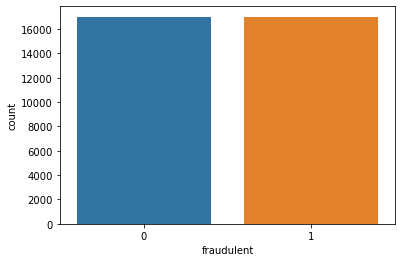

In [478]:
# Visualising the new balanced dataset
sns.countplot(job_postings.fraudulent)
job_postings.groupby('fraudulent').count()['title'].reset_index().sort_values(by='title',ascending=False)

In [381]:
# Importing Label Encoder to convert categorical data into format readable by the model
from sklearn.preprocessing import LabelEncoder

In [382]:
# Converting categorical data to numerical data using LabelEncoder
le = LabelEncoder()
job_postings['title'] = le.fit_transform(job_postings['title'])
job_postings['company_profile'] = le.fit_transform(job_postings['company_profile'])
job_postings['requirements'] = le.fit_transform(job_postings['requirements'])
job_postings['employment_type'] = le.fit_transform(job_postings['employment_type'])
job_postings['required_experience'] = le.fit_transform(job_postings['required_experience'])
job_postings['industry'] = le.fit_transform(job_postings['industry'])
job_postings['function'] = le.fit_transform(job_postings['function'])

In [489]:
# The reset_index() function resets the index of the dataframe, so that the index starts from 0 and is incremented by 1 for each row. If the dataframe has a multi-level index, it removes one or more levels. This is useful for ensuring that the index is consistent and easy to work with.
job_postings = job_postings.reset_index()

In [384]:
# Visualising the top five rows of the balanced dataset
job_postings.head()

,index,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,17688,17689,9881,ap hyderabad,user experience design,1234-12345,1706,looking ux designer help us continuously innov...,174,kill set technology skills proficient interact...,0,0,0,2,6,master degree,29,4,1
1,8702,8703,2139,us ny new york,NaN,NaN,1706,seeking individuals connected companies hiring...,3687,NaN,1,0,0,5,3,high school coursework,131,2,1
2,17554,17555,2899,us ca los angeles,NaN,0-0,1706,need medical transcriptionist transcribe repor...,10426,benefits transcriber position include work hom...,1,0,0,2,3,high school equivalent,79,37,1
3,9842,9843,1341,us ny ny,client services,NaN,1564,url b0c46563ede9cd7db1c4789a59b5459bbd3bc82e0f...,8718,core values drive culture believe url ddb08035...,0,1,1,2,6,bachelor degree,75,7,1
4,10953,10954,7347,us ca san francisco,recruiter network,NaN,88,looking top ranked technical recruiters join n...,11509,access cutting edge marketing sourcing job pos...,0,1,1,0,6,bachelor degree,118,18,1


# Preparing Data for Modelling

In [385]:
# Split data into test and training
from sklearn.model_selection import train_test_split

In [386]:
# Extracting the feature and target data from the job_postings dataframe and storing it in variables X and Y respectively.
X = job_postings[['index', 'title', 'company_profile', 'requirements',
       'telecommuting', 'employment_type',
       'required_experience', 'industry', 'function']].values
Y = job_postings[['fraudulent']].values

In [387]:
# Splitting data into test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [490]:
# Viewing count of split data
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((25501, 40), (8501, 40), (25501, 1), (8507,))

# Applying the models. 3 different classification algorithms will be applied to gain maximum possible accuracy score
**The Algorithms include:**

1) Logistic Regression

2) Random Forest

3) K Nearest Neighbours


***For training these models***

**Independent variable : X
Dependent variable : Y (To if posted job is fake or not)***

# 1. Logistic Regression

In [389]:
#Training the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [390]:
# Creating instance LgR
LgR = LogisticRegression()

In [391]:
# Train the logistic regression model on the training data
LgR.fit(X_train, Y_train)

/Users/keen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/keen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [392]:
# Making predictions on the test data and storing the predicted values.
Y_pred = LgR.predict(X_test)

In [393]:
# Converting to 1-D array
Y_test = Y_test.flatten()
Y_pred = Y_pred.flatten()

In [394]:
# Viewing count
Y_test.shape, Y_pred.shape

((8507,), (8507,))

In [395]:
#Filling the values of Y_test and Y_pred in the respective columns
# To the predicted values with the actual test values and analyze the performance of the logistic regression model.
df_lgr = pd.DataFrame({'Y_test': Y_test , 'Y_pred': Y_pred}) 
df_lgr

,Y_test,Y_pred
0,1,1
1,0,0
2,0,1
3,0,0
4,0,0
...,...,...
8502,0,1
8503,1,1
8504,1,0
8505,1,1


In [396]:
# Checking accuracy score
from sklearn.metrics import accuracy_score

In [397]:
accuracy_score(Y_pred, Y_test)

0.6440578347243446

In [398]:
# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(Y_test, Y_pred))

# Print the classification report
print("Classification Report:")
print(classification_report(Y_test, Y_pred))

Confusion Matrix:
[[2704 1573]
 [1455 2775]]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.63      0.64      4277
           1       0.64      0.66      0.65      4230

    accuracy                           0.64      8507
   macro avg       0.64      0.64      0.64      8507
weighted avg       0.64      0.64      0.64      8507



# The F1-score while using Logistic regression is ~ 64%
The F1-score of 64% means that when the model is presented with new, unseen data and is asked to make a prediction, it correctly balances precision and recall on the data 64% of the time. This can be considered a moderately average performance, but there are  other models that can be compared

# 2. Random Forest Classifier

In [399]:
# Train the model
from sklearn.ensemble import RandomForestClassifier

In [400]:
# Creating an instance of random forest classifier with 5 decision trees.
rfc = RandomForestClassifier(n_estimators=5)

In [401]:
# Train the Random Forest model on the training data
rfc.fit(X_train, Y_train)

/var/folders/3n/c7x7slqd16z7xbdfmsycfvfm0000gn/T/ipykernel_70721/1640918255.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, Y_train)


RandomForestClassifier(n_estimators=5)

In [402]:
# Making predictions on the test data and storing the predicted values.
Y_pred = rfc.predict(X_test)

In [403]:
# Converting to 1-D array
Y_test = Y_test.flatten()
Y_pred = Y_pred.flatten()

In [404]:
#Filling the values of Y_test and Y_pred in the respective columns
# To the predicted values with the actual test values and analyze the performance of the Random Forest Classifier.
df_rfc = pd.DataFrame({'Y_test': Y_test , 'Y_pred': Y_pred}) 
df_rfc

,Y_test,Y_pred
0,1,1
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
8502,0,1
8503,1,1
8504,1,1
8505,1,1


In [463]:
# Viewing count
Y_test.shape, Y_pred.shape

((8507,), (8507,))

In [405]:
# Check Accuracy Score
accuracy_score(Y_pred,Y_test)

0.9961208416598095

In [406]:
# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(Y_test, Y_pred))

# Print the classification report
print("Classification Report:")
print(classification_report(Y_test, Y_pred))

Confusion Matrix:
[[4244   33]
 [   0 4230]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4277
           1       0.99      1.00      1.00      4230

    accuracy                           1.00      8507
   macro avg       1.00      1.00      1.00      8507
weighted avg       1.00      1.00      1.00      8507



# The F1-score using Random Forest Classification Algorithm : 99.7%
The F1-score of 99.7% when using the Random Forest classification algorithm means that when the model is presented with new, unseen data and is asked to make a prediction, it correctly classifies the data 99.7% of the time. This is a very high level of precision and recall, and indicates that the model is effectively identifying patterns in the data.


In [491]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(Y_test, Y_pred)
print(confusion_matrix)

[[3896  381]
 [   0 4230]]


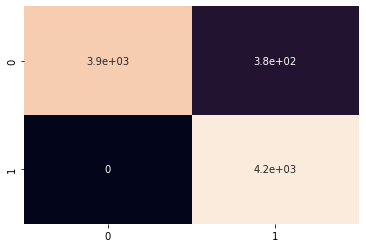

In [492]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix, annot=True, cbar=False)
plt.show()

# 3. K Nearest Neighbours

In [407]:
# Train the model
from sklearn.neighbors import KNeighborsClassifier

In [408]:
# Insitialising KNN classifier
knn = KNeighborsClassifier()

In [409]:
# Train the KNN model on the training data
knn.fit(X_train,Y_train)

/Users/keen/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [410]:
# Making predictions on the test data and storing the predicted values.
Y_pred = knn.predict(X_test)

In [411]:
# Converting to 1-D array
Y_test = Y_test.flatten()
Y_pred = Y_pred.flatten()

In [412]:
#Filling the values of Y_test and Y_pred in the respective columns
# To the predicted values with the actual test values and analyze the performance of the KNN model.
df_knn = pd.DataFrame({'Y_test': Y_test , 'Y_pred': Y_pred}) 
df_knn

,Y_test,Y_pred
0,1,1
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
8502,0,1
8503,1,1
8504,1,1
8505,1,1


In [413]:
# Check the accuracy score
accuracy_score(Y_pred,Y_test)

0.9552133537087105

In [414]:
# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(Y_test, Y_pred))

# Print the classification report
print("Classification Report:")
print(classification_report(Y_test, Y_pred))

Confusion Matrix:
[[3896  381]
 [   0 4230]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      4277
           1       0.92      1.00      0.96      4230

    accuracy                           0.96      8507
   macro avg       0.96      0.96      0.96      8507
weighted avg       0.96      0.96      0.96      8507



# The F1-score using K Nearest Neighbors Algorithm is 96%
The F1-score of 96% when using K Nearest classification algorithm means that when the model is presented with new, unseen data and is asked to make a prediction, it correctly balances precision and recall on the data 96% of the time. This is a very high level and indicates that the model is effectively identifying patterns in the data.

# Deep Learning Model
Comparing the outcome of the machine learning model with the LSTM model

In [419]:
job_postings.head()

,index,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,17688,17689,9881,ap hyderabad,user experience design,1234-12345,1706,looking ux designer help us continuously innov...,174,kill set technology skills proficient interact...,0,0,0,2,6,master degree,29,4,1
1,8702,8703,2139,us ny new york,NaN,NaN,1706,seeking individuals connected companies hiring...,3687,NaN,1,0,0,5,3,high school coursework,131,2,1
2,17554,17555,2899,us ca los angeles,NaN,0-0,1706,need medical transcriptionist transcribe repor...,10426,benefits transcriber position include work hom...,1,0,0,2,3,high school equivalent,79,37,1
3,9842,9843,1341,us ny ny,client services,NaN,1564,url b0c46563ede9cd7db1c4789a59b5459bbd3bc82e0f...,8718,core values drive culture believe url ddb08035...,0,1,1,2,6,bachelor degree,75,7,1
4,10953,10954,7347,us ca san francisco,recruiter network,NaN,88,looking top ranked technical recruiters join n...,11509,access cutting edge marketing sourcing job pos...,0,1,1,0,6,bachelor degree,118,18,1


In [420]:
# Feature selection for modelling
dl_job_postings = job_postings[['description','index', 'title', 'company_profile', 'requirements',
       'telecommuting', 'employment_type',
       'required_experience', 'industry', 'function','fraudulent']]
dl_job_postings.head()

,description,index,title,company_profile,requirements,telecommuting,employment_type,required_experience,industry,function,fraudulent
0,looking ux designer help us continuously innov...,17688,9881,1706,174,0,2,6,29,4,1
1,seeking individuals connected companies hiring...,8702,2139,1706,3687,1,5,3,131,2,1
2,need medical transcriptionist transcribe repor...,17554,2899,1706,10426,1,2,3,79,37,1
3,url b0c46563ede9cd7db1c4789a59b5459bbd3bc82e0f...,9842,1341,1564,8718,0,2,6,75,7,1
4,looking top ranked technical recruiters join n...,10953,7347,88,11509,0,0,6,118,18,1


In [421]:
# Drop Missing  Values
dl_job_postings=dl_job_postings.dropna()

In [422]:
dl_job_postings.shape

(34002, 11)

In [423]:
# Get the Independent Features
X=dl_job_postings.drop('fraudulent',axis=1)

In [424]:
# Get the Dependent features
y=dl_job_postings['fraudulent']

In [425]:
y.value_counts()

0    17014
1    16988
Name: fraudulent, dtype: int64

In [426]:
import tensorflow as tf

In [427]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

In [428]:
# Setting the vocabulary size
voc_size=5000

In [429]:
#One-Hot Representation
message = X.copy()

In [430]:
# accessing the description column of message and prints the value
message['description'][1]

'seeking individuals connected companies hiring employees directly work homes find full time part time opportunities variety career fields including limited data entry customer support billing typing administrative positions guarantee wages ranging per hour six figure salary includes bonuses benefits flexibility work schedule legitimate work home jobs going require skills relevant position applying training provided based position'

In [431]:
# reseting index
message.reset_index(inplace=True)

In [432]:
# Import dependencies
import nltk
import re
from nltk.corpus import stopwords

In [433]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/keen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [434]:
# Perfoming stemming, stop word removal, and converting to lower case using NLTK
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(message)):
    review = re.sub('[^a-zA-Z]', ' ', message['description'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [435]:
# The stemmed and cleaned words are then joined back together into a single string and appended to the corpus list
corpus[1]

'seek individu connect compani hire employe directli work home find full time part time opportun varieti career field includ limit data entri custom support bill type administr posit guarante wage rang per hour six figur salari includ bonus benefit flexibl work schedul legitim work home job go requir skill relev posit appli train provid base posit'

In [436]:
# representing categorical data as numerical data by creating a vocabulary of possible values and converting each value to a binary vector of the same length as the vocabulary.
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
onehot_repr[1]

[612,
 2371,
 1579,
 2734,
 803,
 3079,
 819,
 3021,
 2095,
 1823,
 1997,
 1636,
 4858,
 1636,
 2179,
 861,
 4072,
 3510,
 1407,
 3028,
 4626,
 3395,
 3655,
 255,
 1249,
 380,
 3554,
 447,
 4843,
 3074,
 38,
 1975,
 963,
 1806,
 2979,
 2185,
 1407,
 4774,
 528,
 3419,
 3021,
 765,
 4797,
 3021,
 2095,
 1988,
 4655,
 4632,
 2194,
 837,
 447,
 1901,
 3925,
 2221,
 3124,
 447]

In [437]:
# Using embedding layer to create a dense vector representation of the one-hot encoded words in the input data
sent_length=40
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 2859 2177 4425]
 [4072 3510 1407 ... 2221 3124  447]
 [1794 4453 4731 ...  963 1636 2495]
 ...
 [4488 2475 1658 ... 3659 4707 4846]
 [2958 4435  467 ... 4610 2358 2366]
 [1273 4890 3730 ... 2458 4903  613]]


In [438]:
# Viewing array
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 3777, 4606, 2858, 4090, 2859, 3958,
        174, 3467, 3015, 4336, 2859, 2177, 4425], dtype=int32)

In [439]:
# Creating model
embedding_vector_features=50
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100))) # specifying bidirectional model
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 50)            250000    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              120800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 371,001
Trainable params: 371,001
Non-trainable params: 0
_________________________________________________________________
None


In [440]:
# Viewing distribution
len(embedded_docs),y.shape

(34002, (34002,))

In [441]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [474]:
X_final[1]

array([4072, 3510, 1407, 3028, 4626, 3395, 3655,  255, 1249,  380, 3554,
        447, 4843, 3074,   38, 1975,  963, 1806, 2979, 2185, 1407, 4774,
        528, 3419, 3021,  765, 4797, 3021, 2095, 1988, 4655, 4632, 2194,
        837,  447, 1901, 3925, 2221, 3124,  447], dtype=int32)

In [443]:
# Splitting data into test and training set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.25, random_state=32)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.25, random_state=32)

In [444]:
# Fitting data to model
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=12,batch_size=64)

Epoch 1/12
399/399 [==============================] - 67s 153ms/step - loss: 0.2002 - accuracy: 0.9114 - val_loss: 0.0671 - val_accuracy: 0.9785
Epoch 2/12
399/399 [==============================] - 65s 163ms/step - loss: 0.0456 - accuracy: 0.9881 - val_loss: 0.0496 - val_accuracy: 0.9874
Epoch 3/12
399/399 [==============================] - 61s 153ms/step - loss: 0.0259 - accuracy: 0.9935 - val_loss: 0.0586 - val_accuracy: 0.9818
Epoch 4/12
399/399 [==============================] - 58s 145ms/step - loss: 0.0199 - accuracy: 0.9944 - val_loss: 0.0495 - val_accuracy: 0.9846
Epoch 5/12
399/399 [==============================] - 86s 217ms/step - loss: 0.0087 - accuracy: 0.9982 - val_loss: 0.0331 - val_accuracy: 0.9918
Epoch 6/12
399/399 [==============================] - 56s 139ms/step - loss: 0.0214 - accuracy: 0.9945 - val_loss: 0.0468 - val_accuracy: 0.9873
Epoch 7/12
399/399 [==============================] - 52s 130ms/step - loss: 0.0143 - accuracy: 0.9962 - val_loss: 0.0378 - val_ac

# Model Performance and Accuracy



In [470]:
# Predicted values of target variable for test data
y_pred=model1.predict(X_test)

266/266 [==============================] - 12s 43ms/step


In [471]:
from sklearn.metrics import classification_report

y_pred_class = np.round(y_pred)
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4286
           1       0.99      1.00      0.99      4215

    accuracy                           0.99      8501
   macro avg       0.99      0.99      0.99      8501
weighted avg       0.99      0.99      0.99      8501



In [493]:
from sklearn.metrics import confusion_matrix

y_pred = model1.predict(X_test)
y_pred = np.round(y_pred).flatten()
y_test = y_test.flatten()

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)


266/266 [==============================] - 9s 31ms/step
[[4223   63]
 [   0 4215]]


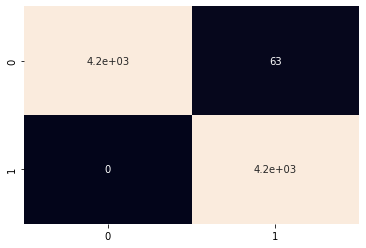

In [494]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix, annot=True, cbar=False)
plt.show()

# Conclusion
***From the models used, the best performing models are the Random forest and the BI-LSTM models with 99.7% and 99% F1-score respectively.***

***The confusion matrix is used to further evaluate the performance of the two classification algorithms. Each column of the matrix represents the instances in a predicted class, while each row represents the instances in an actual class. The first matrix is the confusion matrix for the BI-LSTM model and the second matrix is the confusion matrix for the Random Forest model.***

***In the first matrix, it shows that 3,896 instances were correctly classified as not fraudulent (True Negative) and 4230 instances were correctly classified as fraudulent (True Positive). There were 381 instances that were incorrectly classified as fraudulent (False Positive) and 0 instances that were incorrectly classified as not fraudulent (False Negative).***

***In the second matrix, it shows that 4,223 instances were correctly classified as not fraudulent (True Negative) and 4215 instances were correctly classified as fraudulent (True Positive). There were 63 instances that were incorrectly classified as fraudulent (False Positive) and 0 instances that were incorrectly classified as not fraudulent (False Negative).***

***From the above two confusion matrix, we can see that the Random Forest model has a higher number of False Positives. Therefore, it is less accurate in identifying fraudulent jobs. On the other hand, the BI-LSTM model has higher number of True Positives which means it is better at identifying fraudulent jobs. Thus, based on the confusion matrix, the BI-LSTM model performs better than the Random Forest model in identifying fraudulent jobs.***